In [22]:
from PIL import Image
import torch
from torch import Tensor, linalg
import numpy as np
from IPython.display import Latex
import matplotlib.pyplot as plt

In [23]:
torch.set_default_dtype(torch.float64)

image_count_per_person = 10
person_count = 40
images = [Image.open(f"../data/s{j + 1}/{i + 1}.pgm") for j in range(person_count) for i in range(image_count_per_person)]

#A 3d array
all_data = np.array(images)

#A 2d array (n*d) => (400*10304)
all_data.resize((image_count_per_person * person_count, images[0].width * images[0].height))

all_data = Tensor(all_data)

labels = torch.tensor([i for i in range(person_count) for _ in range(image_count_per_person)])

# Split the Dataset into Training and Test sets
Split dataset into training and test data taking the even indexed rows for testing and the odd indexed rows for training

In [24]:
odd_indices = [i for i in range(len(all_data)) if i % 2 == 1]
even_indices = [i for i in range(len(all_data)) if i % 2 == 0]

training_data = all_data[odd_indices]
test_data = all_data[even_indices]

training_labels = labels[odd_indices]
test_labels = labels[even_indices]

print(training_labels.shape)


torch.Size([200])


# Classification using LDA
## Original LDA Algorithm
Running Time: $O(d^3)$ to calculate the eigen values and eigen vectors of $\Sigma_{d \times d}$ matrix\
\
![lda](../res/lda.PNG)

In [12]:
def LDA(D , y):
    n_features = len(D[0])
    n_classes = len(torch.unique(y))
    
    overall_mean = torch.mean(D ,dim=0)

    # between-class scatter
    Sb = torch.zeros((n_features , n_features))

    # within-class scatter
    S = torch.zeros((n_features , n_features))

    for i in range (n_classes):
        Kth_class = D[y == i]
        cur_mean = torch.mean(Kth_class , dim=0)
       
        # calculate between class scatter matrix
        centered_kth_mean = (cur_mean - overall_mean).unsqueeze(1)
        Sb += (Kth_class.shape[0] * Tensor.matmul(centered_kth_mean,centered_kth_mean.T))

        # calculate within class scatter matrix
        centered_kth_class = Kth_class - cur_mean
        S += Tensor.matmul(centered_kth_class.T,centered_kth_class)


    #compute matrix (S^-1*B) 
    A = linalg.pinv(S) @ Sb
    
    #Compute the eignValues and eignVectors
    eigenvalues, eigenvectors = linalg.eig(A)
    eigenvalues, eigenvectors =eigenvalues.real, eigenvectors.real
    
    #Sort the eignValues and eignVectors
    idxs = torch.argsort(eigenvalues,descending=True)
    eigenvectors = eigenvectors[:,idxs]

    return eigenvectors[:,:n_classes-1]

In [13]:
def knn(test_data: Tensor, training_data: Tensor, k: int):
    distance_matrix = torch.cdist(test_data, training_data)
    indices = torch.argsort(distance_matrix, dim=1)
    return indices[:, :k]

In [14]:
def lda_classify(training_data, test_data, training_labels, test_labels, k):
    projection_matrix = LDA(training_data,training_labels) 
    projected_training_matrix = training_data @ projection_matrix
    projected_test_matrix = test_data @ projection_matrix
    
    result_labels = training_labels[knn(projected_test_matrix,projected_training_matrix, k)].mode(keepdim=True)[0]
    return 1 - torch.count_nonzero(result_labels - test_labels[:, None]) / len(result_labels)
    

In [15]:
# projection_matrix = LDA(training_data,training_labels)   #(10304 * 39)
# print("projection_matrix Dimension : ",projection_matrix.shape)

# projected_training_matrix = training_data @ projection_matrix
# projected_test_matrix = test_data @ projection_matrix

# print("Done Projection")
# print("projected_training_matrix Dimension : ",projected_training_matrix.shape)
# k = 1

# result_labels = training_labels[knn(projected_test_matrix,projected_training_matrix, k)].mode(keepdim=True)[0]
# print("Accuracy: ",1 - torch.count_nonzero(result_labels - test_labels[:, None]) / len(result_labels))


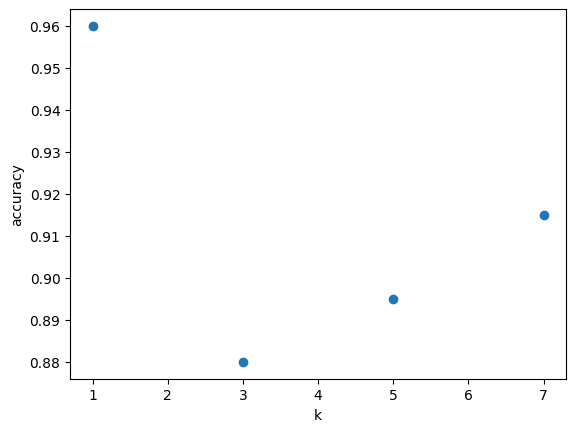

In [16]:
ks = [1, 3, 5, 7]
alpha = 0.9

accuracies = [lda_classify(training_data, test_data, training_labels, test_labels, k) for k in ks]
plt.xlabel("k")
plt.ylabel("accuracy")
plt.scatter(ks, accuracies)

# Bonus
## Linear Regularized Discriminant Analysis(RDA)


In [42]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

# Create and fit the regularized discriminant analysis model
rda = LinearDiscriminantAnalysis(solver='eigen',shrinkage=0.5)
rda.fit(training_data, training_labels)

# Make predictions on the test set
y_pred = rda.predict(test_data)

# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.975
